<a href="https://colab.research.google.com/github/thuongvan23/XAI-LandCover/blob/kienNB/Capstone_MobileNet13Bands_Unfrozen50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle tifffile rasterio


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.2 MB/s eta 0:00:00


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d apollo2506/eurosat-dataset
!unzip -q eurosat-dataset.zip -d ./eurosat_data


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:16<00:00, 121MB/s] 
100% 2.04G/2.04G [00:16<00:00, 131MB/s]


Shape của ảnh: (64, 64, 13)


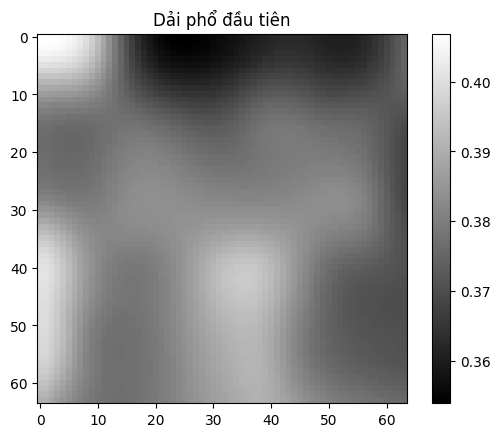

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/eurosat_data/EuroSATallBands/AnnualCrop/AnnualCrop_1.tif"
img = tiff.imread(img_path)
img_normalized = img / np.max(img)
print("Shape của ảnh:", img.shape)
plt.imshow(img_normalized[:, :, 0], cmap='gray')
plt.title("Dải phổ đầu tiên")
plt.colorbar()
plt.show()


In [ ]:
import os
root_dir = "/content/eurosat_data/EuroSATallBands"
for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")


EuroSATallBands/
  test.csv
  validation.csv
  label_map.json
  train.csv
  Industrial/
    Industrial_2499.tif
    Industrial_1893.tif
    Industrial_327.tif
    Industrial_928.tif
    Industrial_58.tif
  Residential/
    Residential_2678.tif
    Residential_2937.tif
    Residential_1563.tif
    Residential_2032.tif
    Residential_1486.tif
  AnnualCrop/
    AnnualCrop_1606.tif
    AnnualCrop_325.tif
    AnnualCrop_1185.tif
    AnnualCrop_2415.tif
    AnnualCrop_266.tif
  SeaLake/
    SeaLake_1971.tif
    SeaLake_2675.tif
    SeaLake_2896.tif
    SeaLake_2215.tif
    SeaLake_1093.tif
  Pasture/
    Pasture_1368.tif
    Pasture_209.tif
    Pasture_1953.tif
    Pasture_1732.tif
    Pasture_1415.tif
  River/
    River_1206.tif
    River_2370.tif
    River_274.tif
    River_2466.tif
    River_624.tif
  PermanentCrop/
    PermanentCrop_2412.tif
    PermanentCrop_1797.tif
    PermanentCrop_31.tif
    PermanentCrop_2158.tif
    PermanentCrop_562.tif
  HerbaceousVegetation/
    HerbaceousVege

In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Tạo transform
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    ToTensorV2(transpose_mask=True),
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
from torchvision import transforms

class EuroSATCSV(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['Filename'])
        label = int(row['Label'])

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)  # (13, 64, 64)
            img = img / 10000.0  # Scale về [0, 1]
            img = np.transpose(img, (1, 2, 0))   # Chuyển thành (H, W, C) cho albumentations

        if self.transform:
            img = self.transform(image=img)["image"]  # Albumentations trả về dict

        return img, label

In [ ]:
base_path = "/content/eurosat_data/EuroSATallBands"

train_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "train.csv"),
    root_dir=base_path,
    transform=train_transform
)

val_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "validation.csv"),
    root_dir=base_path,
)

test_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "test.csv"),
    root_dir=base_path,
)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
from torchvision.models import mobilenet_v2

class MobileNet13Bands(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet13Bands, self).__init__()

        self.model = mobilenet_v2(pretrained=True)
        self.model.features[0][0] = nn.Conv2d(13, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
        total_layers = len(list(self.model.features))
        freeze_until = total_layers // 2

        for idx, child in enumerate(self.model.features.children()):
            if idx < freeze_until:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.model(x)


In [ ]:
import copy
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNet13Bands(num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in dataloader:
        # Nếu input có 4 chiều và channels ở cuối (thường là (N,H,W,C))
        if inputs.dim() == 4 and inputs.shape[-1] == 13:
            inputs = inputs.permute(0, 3, 1, 2).contiguous()  # chuyển sang (N,C,H,W)

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            if inputs.dim() == 4 and inputs.shape[-1] == 13:
                inputs = inputs.permute(0, 3, 1, 2).contiguous()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=7):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        scheduler.step(val_loss)  # Giảm LR khi val_loss không cải thiện

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model

# Huấn luyện model
model = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=7)

# Đánh giá trên tập test
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 36.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

Epoch 1/50
  Train Loss: 0.5585 | Train Acc: 0.8187
  Val   Loss: 0.2324 | Val   Acc: 0.9232
  Current LR: 0.001000
Epoch 2/50
  Train Loss: 0.4010 | Train Acc: 0.8705
  Val   Loss: 0.2312 | Val   Acc: 0.9237
  Current LR: 0.001000
Epoch 3/50
  Train Loss: 0.3482 | Train Acc: 0.8885
  Val   Loss: 0.2081 | Val   Acc: 0.9302
  Current LR: 0.001000
Epoch 4/50
  Train Loss: 0.3225 | Train Acc: 0.8928
  Val   Loss: 0.2417 | Val   Acc: 0.9252
  Current LR: 0.001000
Epoch 5/50
  Train Loss: 0.3037 | Train Acc: 0.9008
  Val   Loss: 0.1845 | Val   Acc: 0.9368
  Current LR: 0.001000
Epoch 6/50
  Train Loss: 0.2922 | Train Acc: 0.9043
  Val   Loss: 0.1799 | Val   Acc: 0.9400
  Current LR: 0.001000
Epoch 7/50
  Train Loss: 0.2782 | Train Acc: 0.9085
  Val   Loss: 0.2790 | Val   Acc: 0.9350
  Current LR: 0.001000
Epoch 8/50
  Train Loss: 0.2629 | Train Acc: 0.9115
  Val   Loss: 0.1607 | Val   Acc: 0.9484
  Current LR: 0.001000
Epoch 9/50
  Train Loss: 0.2488 | Train Acc: 0.9158
  Val   Loss: 0.1422

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/mobilenet13bands_unfrozen50.pth"
torch.save(model, save_path)
